# MPC

In [1]:
#!pip install cvxpy

## Librerias
En este primer bloque simplemente se documenta el objetivo del script y se importan las librerías necesarias. 
El comentario inicial indica que se implementa un controlador predictivo (MPC) para un edificio con cuatro salones 
y que se comparan dos configuraciones distintas del controlador: una agresiva y otra intermedia.

Luego se importa `numpy` como `np`, que se utilizará para todas las operaciones de álgebra matricial 
(definición del modelo en espacio de estados, vectores de estado, entradas, etc.).

La librería `cvxpy` se importa como `cp`; esta es fundamental porque permite formular y resolver el problema 
de optimización convexa que define el MPC (minimización del costo sujeto a las restricciones dinámicas y de saturación).

Finalmente, `matplotlib.pyplot` se importa como `plt` para poder generar las gráficas de la evolución de las 
temperaturas y las potencias de los actuadores en el tiempo.

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Parametros Iniciales

En este bloque se definen los parámetros físicos que caracterizan la dinámica térmica de los salones. 
La constante `c` representa la **capacitancia térmica** equivalente de cada salón en unidades de J/°C; 
este valor aparece en el enunciado del proyecto y resume la capacidad del salón para almacenar energía térmica 
(cuanto mayor es `c`, más “pesada” es la temperatura, es decir, más lentamente cambia ante una entrada de calor). 

El parámetro `alpha` corresponde a las **pérdidas térmicas** en W/°C, que modelan la transferencia de calor hacia el exterior 
y entre salones adyacentes. La temperatura ambiente `T_ambiente` se fija en 8 °C, tal como se plantea en el taller, 
y representa una condición externa constante.

A continuación se construye la matriz `A`, que es la matriz de dinámica del sistema continuo en espacio de estados. 
Cada elemento de `A` se obtiene a partir del balance de energía de cada salón. Los términos de la diagonal son negativos 
y están escalados por `alpha/c`; por ejemplo, en la primera fila aparece `-2*alpha/c`, lo que refleja que el salón 1 pierde 
calor tanto hacia el ambiente como hacia el salón 2. 

Los términos `alpha/c` fuera de la diagonal representan el acoplamiento térmico entre salones vecinos: por ejemplo, 
el término `alpha/c` en la posición (1,2) indica que la temperatura del salón 2 influye positivamente en la del salón 1 a través 
del flujo de calor entre ellos. La estructura simétrica de esta matriz refleja que los intercambios de calor entre salones son recíprocos.

La matriz `B` agrupa en sus columnas el efecto de las entradas de control (potencias de los calefactores) 
y el efecto de la temperatura ambiente. En las primeras cuatro columnas se colocan términos `1/c` o ceros: 
cada fila tiene un `1/c` en la columna asociada al calefactor del propio salón, lo que significa que la potencia `u_i` 
inyecta energía directamente en el salón i y aumenta su temperatura según la relación de balance térmico. 

La quinta columna contiene `alpha/c` en todas las filas, lo que representa el impacto de la temperatura ambiente sobre cada salón, 
modelado como una especie de “perturbación constante” que empuja la temperatura hacia 8 °C.

Estos valores no se escogieron arbitrariamente: vienen del modelo físico establecido en el enunciado y garantizan 
que el comportamiento simulado del edificio sea coherente con la dinámica térmica descrita en el proyecto.



In [3]:
c = 7.476e4       
alpha = 123.6      
T_ambiente = 8.0   

# Matriz A (dinámica térmica)
A = np.array([
    [-2*alpha/c,  alpha/c,       0.0,        0.0],
    [ alpha/c,   -3*alpha/c,  alpha/c,       0.0],
    [ 0.0,        alpha/c,   -3*alpha/c,  alpha/c],
    [ 0.0,        0.0,        alpha/c,   -2*alpha/c]
])

B = np.array([
    [1/c, 0.0, 0.0, 0.0, alpha/c],
    [0.0, 1/c, 0.0, 0.0, alpha/c],
    [0.0, 0.0, 1/c, 0.0, alpha/c],
    [0.0, 0.0, 0.0, 1/c, alpha/c]
])

Después de definir el modelo continuo, se separan las contribuciones de las entradas de control y de la perturbación ambiente. 
La instrucción `B_act = B[:, :4]` toma las primeras cuatro columnas de `B`, que corresponden exclusivamente a las potencias de los cuatro calefactores; esto da una matriz de tamaño 4×4 que se usará como matriz de entrada del sistema controlable. Por otro lado, `B_amb = B[:, 4].reshape(-1, 1)` extrae la quinta columna y la convierte en un vector columna 4×1, que representa el efecto del ambiente como una entrada constante multiplicada por la temperatura `T_ambiente`. La línea `T_ref = np.array([22.0, 21.0, 20.0, 19.0])` fija el vector de **temperaturas de referencia** para cada salón. Estos valores corresponden exactamente a las consignas requeridas en el proyecto:  
22 °C para el salón 1, 21 °C para el salón 2, 20 °C para el salón 3 y 19 °C para el salón 4. Luego se definen `n = 4` y `m = 4` para dejar explícito que existen cuatro estados (temperaturas) y cuatro entradas de control (potencias).

A continuación se realiza la discretización del modelo usando el método de Euler hacia adelante. El paso de muestreo `Ts` se fija en 60 segundos (un minuto), decisión razonable para sistemas térmicos que evolucionan lentamente; un paso más pequeño aumentaría el costo computacional sin aportar mucho detalle adicional, y uno más grande podría deteriorar la aproximación del modelo. La matriz identidad `I4 = np.eye(4)` se utiliza para construir `A_d = I4 + Ts * A`, que es una aproximación discreta del sistema continuo \dot{x} = A x. De forma análoga, `B_act_d = Ts * B_act` y `B_amb_d = Ts * B_amb` son las matrices de entrada discretizadas, obtenidas multiplicando por el período de muestreo. Estos modelos discretos son los que realmente utiliza el MPC en las predicciones futuras.



In [4]:
# Separar actuadores y efecto del ambiente

B_act = B[:, :4]          # 4 calefactores
B_amb = B[:, 4].reshape(-1, 1)

# Referencias por salón

T_ref = np.array([22.0, 21.0, 20.0, 19.0])

n = 4   # estados
m = 4   # entradas

# DISCRETIZACIÓN (EULER)

Ts = 60.0 

I4 = np.eye(4)
A_d = I4 + Ts * A
B_act_d = Ts * B_act
B_amb_d = Ts * B_amb

## Controlador MPC Parametrizado 

Esta función implementa el corazón del controlador predictivo. 
La firma de la función recibe el estado actual del sistema (`estado_actual`), el vector de referencias (`T_ref`), 
las matrices de ponderación del costo `Q` y `R`, el horizonte de predicción `Np`, y opcionalmente la última entrada aplicada (`u_anterior`) 
junto con los límites mínimo y máximo de potencia (`u_min`, `u_max`).

En las primeras líneas dentro de la función se declaran las variables de decisión del problema de optimización mediante `cvxpy`. 
La variable `X = cp.Variable((n, Np + 1))` es una matriz que almacenará las predicciones futuras de los estados desde el instante actual 
hasta el paso `Np`; por eso tiene `Np + 1` columnas. La variable `U = cp.Variable((m, Np))` contiene la secuencia de entradas futuras 
a lo largo del horizonte. La variable escalar `costo` se inicializa en cero y la lista `restricciones` se usará para acumular 
todas las ecuaciones e desigualdades del problema.

La primera restricción impone la condición de estado inicial: `X[:, 0] == estado_actual`, lo que obliga a que la primera columna de `X` coincida exactamente con el estado medido del edificio en el instante actual. Esto asegura que la predicción arranque desde la temperatura real y no desde un valor arbitrario.

Luego se entra en un bucle sobre el índice `k` que recorre todos los pasos de predicción desde 0 hasta `Np-1`. Dentro de este bucle, la primera instrucción de interés define la dinámica discreta del sistema. `X[:, k+1] == A_d @ X[:, k] + B_act_d @ U[:, k] + B_amb_d.flatten() * T_ambiente`

La ecuación de dinámica dentro del bucle impone que el estado predicho en el paso siguiente (`X[:, k+1]`) se obtenga aplicando el modelo discreto a partir del estado actual `X[:, k]`, de la entrada `U[:, k]` y de la perturbación generada por la temperatura ambiente. Esta ecuación es la versión en espacio de estados del balance energético por salón.

A continuación se añaden las restricciones de saturación de los actuadores. Las inequaciones `U[:, k] >= u_min` y `U[:, k] <= u_max` fuerzan que cada componente de la entrada predicha permanezca entre 0 y 5000 W. Esto modela las capacidades físicas reales de los calefactores: no pueden extraer energía negativa (no hay refrigeración) ni superar una potencia máxima.

Seguidamente se define la contribución al costo que penaliza el error de temperatura. Se calcula `error_k = X[:, k] - T_ref`, que es el vector de diferencias entre la temperatura predicha y la referencia en el paso `k`. La función `cp.quad_form(error_k, Q)` evalúa el término cuadrático \( e_k^\top Q e_k \), donde `Q` es una matriz diagonal de ponderaciones.  
Si los valores de `Q` son grandes, el problema de optimización considera muy costosos los errores de temperatura, empujando al controlador a reducirlos rápidamente.

Luego se incluye la penalización por esfuerzo de control mediante `costo += cp.quad_form(U[:, k], R)`. Este término añade \( u_k^\top R u_k \) al costo total y permite castigar el uso de potencias elevadas. Una matriz `R` pequeña hace que el uso de energía casi no penalice y favorece acciones agresivas; una matriz `R` más grande hace que al algoritmo le importe ahorrar energía, incluso si eso introduce cierto error.

Una vez terminado el bucle, se define un término de costo terminal adicional basado en el estado en el último instante de predicción `X[:, Np]`.  
El vector `error_final = X[:, Np] - T_ref` mide el error en el extremo del horizonte y la llamada `cp.quad_form(error_final, 50 * Q)` multiplica la matriz `Q` por 50 para reforzar esta penalización. Esto incentiva que, al final del horizonte, el sistema esté lo más cerca posible de la referencia, evitando soluciones que “se duerman” al final.

Finalmente se arma el problema de optimización con `problema = cp.Problem(cp.Minimize(costo), restricciones)` y se resuelve con el solver OSQP.  
Si el estado del problema no es óptimo (por ejemplo, si el solver fallara), se devuelve la última entrada aplicada o un vector de ceros como mecanismo de seguridad.  

En el caso normal, se extrae la primera columna de `U (U.value[:, 0])`, que es la acción de control que se aplicará en el instante actual, y se satura numéricamente con `np.clip` para garantizar que respeta exactamente los límites `u_min` y `u_max`.  

Esta es la esencia del MPC: de toda la secuencia óptima calculada solo se aplica el primer control, y el resto se recalcula en el siguiente instante.



In [5]:
def controlador_mpc_param(estado_actual, T_ref, Q, R, Np,
                          u_anterior=None,
                          u_min=0.0, u_max=5000.0):
   
    X = cp.Variable((n, Np + 1))
    U = cp.Variable((m, Np))

    costo = 0
    restricciones = []

    # Estado inicial
    restricciones.append(X[:, 0] == estado_actual)

    for k in range(Np):
        
        # Dinámica del edificio
        restricciones.append(
            X[:, k+1] == A_d @ X[:, k] + B_act_d @ U[:, k] +
            B_amb_d.flatten() * T_ambiente
        )

      
        restricciones.append(U[:, k] >= u_min)
        restricciones.append(U[:, k] <= u_max)

        # Costo de error de temperatura
        error_k = X[:, k] - T_ref
        costo += cp.quad_form(error_k, Q)

        # Costo de esfuerzo y energía
        costo += cp.quad_form(U[:, k], R)


    error_final = X[:, Np] - T_ref
    costo += cp.quad_form(error_final, 50 * Q)

    problema = cp.Problem(cp.Minimize(costo), restricciones)
    problema.solve(solver=cp.OSQP, verbose=False)

    if problema.status not in ["optimal", "optimal_inaccurate"]:
 
        if u_anterior is not None:
            return u_anterior
        else:
            return np.zeros(m)

    u_opt = U.value[:, 0]
    return np.clip(u_opt, u_min, u_max)


## Simulación MPC configuraciones

Esta función realiza la simulación completa del edificio en lazo cerrado con un controlador MPC parametrizado por matrices `Q`, `R` y horizonte `Np`. Se incluye también un nombre descriptivo de la configuración para utilizarlo luego en las gráficas. El parámetro `T_inicial` permite definir las temperaturas iniciales de los salones; si no se especifica, se asume que todos comienzan a 8 °C, es decir, en equilibrio con la temperatura ambiente. Además, se define el tiempo de simulación en horas (por defecto, 1 h), que se convierte a segundos en `tiempo_sim = tiempo_sim_horas * 60 * 60`. Dividiendo este tiempo total entre el período de muestreo `Ts` se obtiene `N_pasos`, el número total de iteraciones de control. Se construye el vector de tiempo `hist_t` con `np.arange(N_pasos + 1) * Ts`, que contiene el instante de cada muestra desde 0 hasta el final. Las matrices `hist_T` y `hist_u` se inicializan con ceros para almacenar la historia de las temperaturas y de las potencias respectivamente. El estado actual `T_actual` se inicializa con una copia de `T_inicial` y `u_actual` se fija como un vector de ceros, suponiendo que al inicio los calefactores están apagados. Se registra la condición inicial asignando `hist_T[0, :] = T_actual`. El ciclo `for k in range(N_pasos)` implementa la evolución en el tiempo. En cada iteración se llama a `controlador_mpc_param`, entregándole el estado actual y los parámetros del controlador. Esta función devuelve la acción óptima `u_mpc` que se debe aplicar en ese minuto. Con esa entrada se actualiza la temperatura mediante el modelo discreto: `T_siguiente = A_d @ T_actual + B_act_d @ u_mpc + B_amb_d.flatten() * T_ambiente`. La potencia aplicada y la nueva temperatura se almacenan en `hist_u` y `hist_T`, y luego se actualizan las variables `T_actual` y `u_actual` para la siguiente iteración. Una vez que termina la simulación, se calcula la **energía total consumida por salón**. Esto se hace sumando la potencia de cada salón a lo largo de todo el horizonte (`np.sum(hist_u, axis=0)`) y multiplicando por el intervalo de muestreo `Ts`, recordando que energía = potencia × tiempo. El resultado es un vector de cuatro valores en Joules que cuantifica cuánta energía ha consumido cada calefactor. Finalmente se construye un diccionario con todo lo relevante: el nombre de la configuración, el tiempo, la historia de temperaturas, las potencias y la energía consumida, que se devuelve para ser analizado o graficado.


In [6]:
def simular_mpc(Q, R, Np, nombre_config,
                T_inicial=None,
                tiempo_sim_horas=1,
                u_min=0.0, u_max=5000.0):
  
    if T_inicial is None:
        T_inicial = np.array([8.0, 8.0, 8.0, 8.0])

    tiempo_sim = tiempo_sim_horas * 60 * 60
    N_pasos = int(tiempo_sim / Ts)

    hist_t = np.arange(N_pasos + 1) * Ts
    hist_T = np.zeros((N_pasos + 1, n))
    hist_u = np.zeros((N_pasos, m))

    T_actual = T_inicial.copy()
    u_actual = np.zeros(m)

    hist_T[0, :] = T_actual

    for k in range(N_pasos):
        u_mpc = controlador_mpc_param(
            T_actual, T_ref, Q, R, Np, u_anterior=u_actual,
            u_min=u_min, u_max=u_max
        )

        T_siguiente = A_d @ T_actual + B_act_d @ u_mpc + \
                      B_amb_d.flatten() * T_ambiente

        hist_u[k, :] = u_mpc
        hist_T[k+1, :] = T_siguiente

        T_actual = T_siguiente
        u_actual = u_mpc

    # Energía por salón (J = W * s)
    energia_por_salon = np.sum(hist_u, axis=0) * Ts

    resultados = {
        "nombre": nombre_config,
        "hist_t": hist_t,
        "hist_T": hist_T,
        "hist_u": hist_u,
        "energia": energia_por_salon
    }
    return resultados

## Graficas Configuraciones MPC

La función `graficar_configuracion` recibe el diccionario de resultados de una simulación y genera una figura con ocho subgráficas organizadas en cuatro filas (una por salón) y dos columnas (temperatura y potencia). Se extraen primero los vectores y matrices relevantes (`hist_t`, `hist_T`, `hist_u`) y se convierten los tiempos de segundos a minutos con `tiempo_min = hist_t / 60.0`. Para las potencias se usa `tiempo_min_u = tiempo_min[:-1]` porque `hist_u` tiene una muestra menos que `hist_T` (no hay control en el instante final). La llamada a `plt.subplots(4, 2, figsize=(12, 12), sharex="col")` crea la rejilla de subgráficas con un tamaño de figura suficiente para que cada gráfico sea legible. Se añade un título general con `fig.suptitle`, que incluye el nombre de la configuración (por ejemplo, “MPC Cambios”). Dentro del bucle `for i in range(4)` se trata cada salón por separado. En la columna izquierda (`axs[i, 0]`) se grafica la temperatura real del salón con `axT.plot(tiempo_min, hist_T[:, i], ...)` y se dibuja su referencia correspondiente con `axT.hlines(T_ref[i], ...)` como línea punteada. Esto permite visualizar claramente si la temperatura se acerca o no a la consigna. Se añaden también etiquetas de ejes, títulos, rejilla y leyenda para facilitar la interpretación. En la columna derecha (`axs[i, 1]`) se muestra la potencia del actuador del mismo salón usando `axU.step`, que resalta que las potencias se mantienen constantes dentro de cada intervalo de muestreo y cambian de forma escalonada. De nuevo se agregan etiquetas, título y leyenda. Al final se fijan las etiquetas del eje x únicamente en la última fila para no saturar el gráfico y se ajusta el layout con `plt.tight_layout` para evitar solapamiento entre subgráficas y títulos. Después de mostrar la figura, la función imprime en consola el vector de energía consumida por salón, lo que es útil para comparar cuantitativamente la eficiencia de distintas configuraciones.


In [7]:
def graficar_configuracion(resultados):
   
    nombre = resultados["nombre"]
    hist_t = resultados["hist_t"]
    hist_T = resultados["hist_T"]
    hist_u = resultados["hist_u"]

    tiempo_min = hist_t / 60.0
    tiempo_min_u = tiempo_min[:-1]

    fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharex="col")
    fig.suptitle(f"Comparativa MPC - {nombre}", fontsize=14)

    for i in range(4):
        # Columna izquierda: temperatura
        axT = axs[i, 0]
        axT.plot(tiempo_min, hist_T[:, i], label=f"T salón {i+1}")
        axT.hlines(T_ref[i], 0, tiempo_min[-1],
                   linestyles="dashed", label=f"Ref salón {i+1}")
        axT.set_ylabel("Temp [°C]")
        axT.set_title(f"Temperatura salón {i+1}")
        axT.grid(True)
        axT.legend(loc="best")

        # Columna derecha: potencia
        axU = axs[i, 1]
        axU.step(tiempo_min_u, hist_u[:, i], where="post",
                 label=f"u salón {i+1}")
        axU.set_ylabel("Potencia [W]")
        axU.set_title(f"Actuador salón {i+1}")
        axU.grid(True)
        axU.legend(loc="best")

    axs[-1, 0].set_xlabel("Tiempo [min]")
    axs[-1, 1].set_xlabel("Tiempo [min]")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Imprimir energía usada
    print(f"[{nombre}] Energía [J] por salón:", resultados["energia"])


## Definicion de Parametros 

En este bloque se definen explícitamente los parámetros que diferencian a las dos variantes del MPC utilizadas en el proyecto. Para ambas configuraciones se utilizan matrices `Q` y `R` diagonales, lo que significa que cada salón y cada actuador se ponderan de forma independiente pero simétrica. En la configuración denominada **MPC con cambios** se escoge `Q_agresivo = diag(10, 10, 10, 10)`. Esto implica que cualquier desviación de la temperatura respecto a la referencia tiene un peso elevado en el costo, y se le da la misma importancia a los cuatro salones. La matriz `R_agresivo = 1e-5 * I` es extremadamente pequeña; en términos prácticos, el costo asociado a usar potencia de calefacción es casi despreciable. Combinado con un horizonte de predicción largo (`Np_agresivo = 30`, es decir, 30 minutos hacia adelante), esto hace que el controlador priorice de forma muy fuerte el cumplimiento rápido de las referencias, sin preocuparse demasiado por el consumo energético. Esta elección se hizo intencionalmente para obtener una política de “confort máximo”, útil para comparar con otras opciones más conservadoras. En contraste, la configuración **MPC inicial** busca un compromiso más equilibrado entre comodidad térmica y eficiencia energética. Aquí se reduce ligeramente la importancia del error de temperatura con `Q_intermedio = diag(8, 8, 8, 8)` y se incrementa significativamente la penalización del uso de potencia con `R_intermedio = 1e-4 * I`, que es diez veces mayor que en el caso agresivo. Además, el horizonte de predicción se acorta a `Np_intermedio = 20` minutos, lo que reduce la anticipación y produce respuestas algo más suaves. En conjunto, estos ajustes hacen que el controlador esté dispuesto a tolerar pequeños errores (por ejemplo, quedándose 0.5–1 °C por debajo de la referencia) a cambio de reducir notablemente la energía consumida.

In [8]:
# Configuración con cambios
Q_agresivo = np.diag([10.0, 10.0, 10.0, 10.0])
R_agresivo = 1e-5 * np.eye(m)
Np_agresivo = 30

# Configuración parametros iniciales
Q_intermedio = np.diag([8.0, 8.0, 8.0, 8.0])
R_intermedio = 1e-4 * np.eye(m)
Np_intermedio = 20

En el bloque final se llaman las funciones de simulación para cada una de las configuraciones definidas. La primera llamada ejecuta la simulación con los parámetros agresivos y etiqueta la configuración como `"MPC Cambios"`, que es la variante centrada en alcanzar rápidamente la referencia. La segunda llamada utiliza los parámetros intermedios y la etiqueta `"MPC inicial"`, que representa una política más moderada en términos de energía. Cada simulación genera un conjunto de trayectorias de temperatura y potencia, así como el cálculo de la energía consumida por salón. Finalmente, `graficar_configuracion` se invoca dos veces para producir los diagramas 4×2 que muestran, para cada salón, la evolución de la temperatura respecto a su referencia y la señal de control asociada, además de imprimir las energías totales. En tus gráficas, esto se traduce en que el MPC agresivo hace que los cuatro salones alcancen sus referencias en pocos minutos, con potencias que inicialmente se saturan y luego se estabilizan en un nivel medio elevado. Por otro lado, el MPC intermedio hace que las temperaturas suban más pausadamente y se queden un poco por debajo de la consigna, mientras que las potencias iniciales son menos extremas y la energía acumulada es sensiblemente menor. Esta comparación respalda la interpretación de que el MPC te permite diseñar políticas distintas según la prioridad del operador: confort máximo a costa de más energía, o ahorro de energía aceptando un pequeño sacrificio en temperatura.



In [9]:
%%time
res_intermedio = simular_mpc(Q_intermedio, R_intermedio, Np_intermedio,

                             nombre_config="MPC inicial")

CPU times: user 17.4 s, sys: 39.1 ms, total: 17.4 s
Wall time: 17.8 s


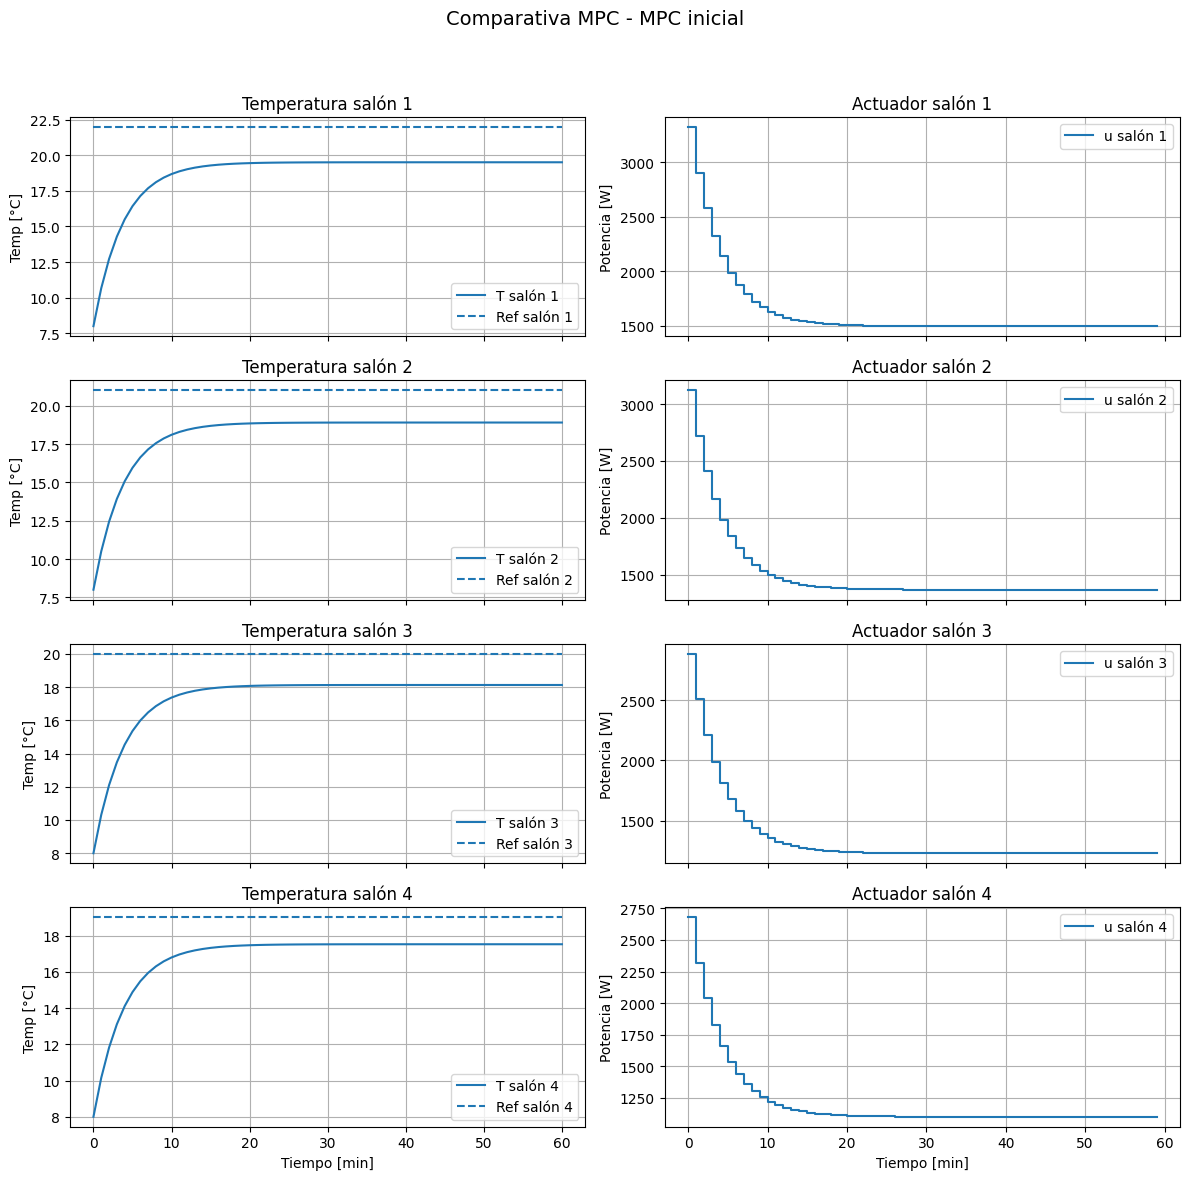

[MPC inicial] Energía [J] por salón: [5866922.79158192 5381088.55351154 4866879.04219812 4381044.80412774]


In [10]:
graficar_configuracion(res_intermedio)

In [11]:
%%time
res_agresivo = simular_mpc(Q_agresivo, R_agresivo, Np_agresivo,
                           nombre_config="MPC Cambios")

CPU times: user 28.2 s, sys: 41.5 ms, total: 28.2 s
Wall time: 28.7 s


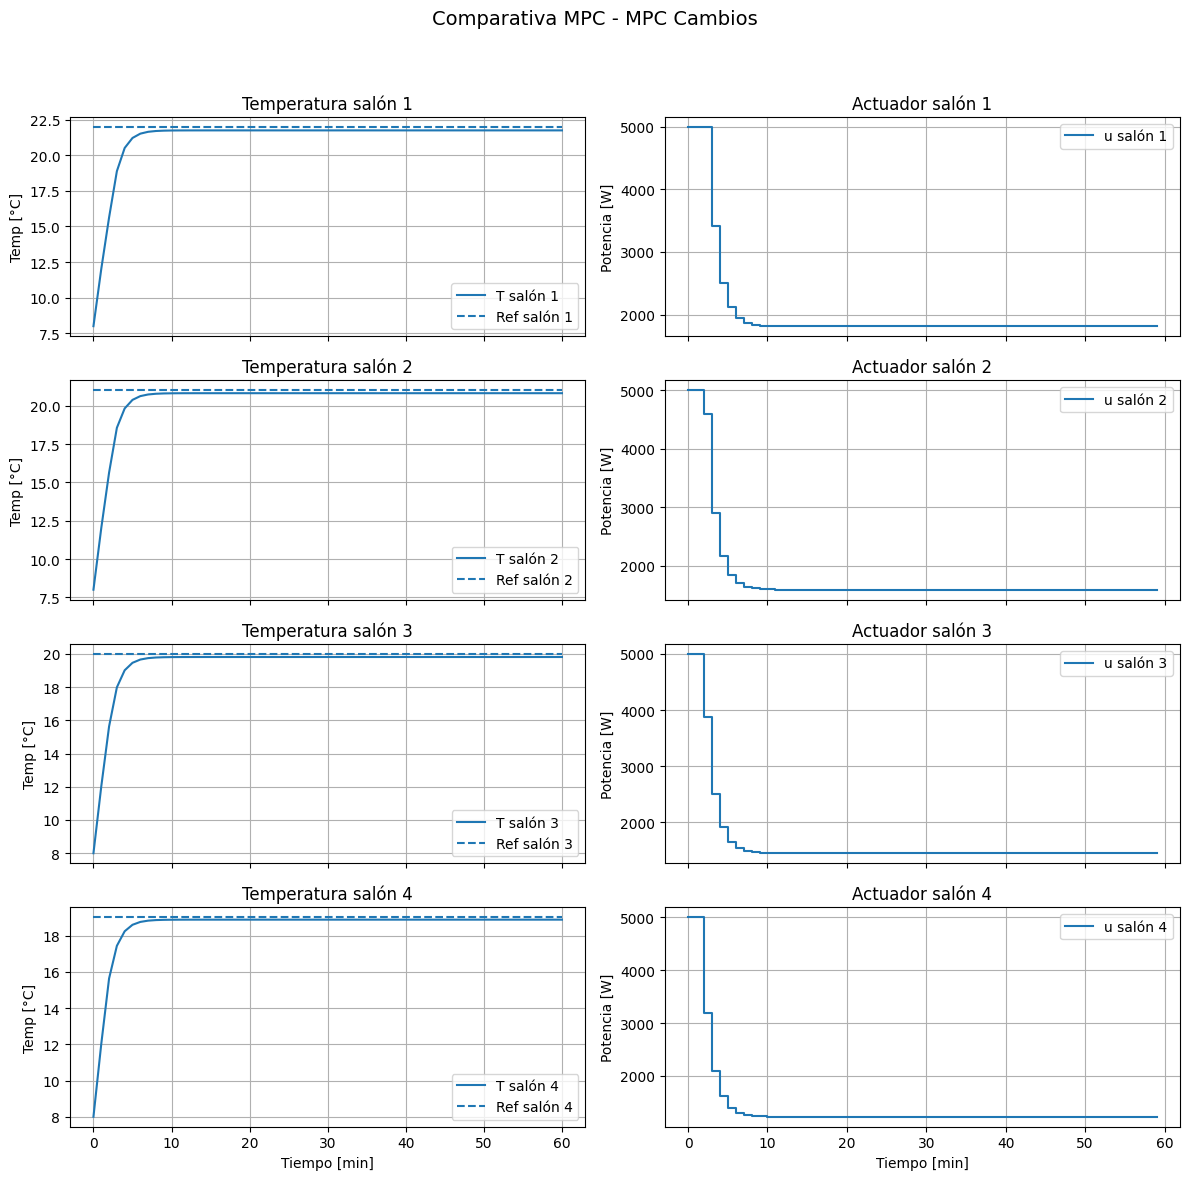

[MPC Cambios] Energía [J] por salón: [7275976.18093433 6461213.71943879 5909875.80217732 5087057.70308645]


In [12]:
graficar_configuracion(res_agresivo)

In [13]:
import pandas as pd 

def calcular_metricas(resultados, T_ref, Ts,
                      banda_est=0.5, frac_ss=0.25):
  
    hist_t = resultados["hist_t"]     
    hist_T = resultados["hist_T"]   
    hist_u = resultados["hist_u"]      

    N_pasos = hist_u.shape[0]
    n_salones = hist_T.shape[1]
  
    tiempos_est_s = np.full(n_salones, np.nan)

    for i in range(n_salones):
        error_abs = np.abs(hist_T[:, i] - T_ref[i])

        for k in range(len(error_abs)):
            if np.all(error_abs[k:] <= banda_est):
                tiempos_est_s[i] = hist_t[k]  # segundos
                break

    idx_ss_ini = int((1.0 - frac_ss) * N_pasos)

  
    u_ss = hist_u[idx_ss_ini:, :]       

    T_ss = hist_T[idx_ss_ini+1:, :]    

 
    potencia_ss_W = np.mean(u_ss, axis=0)

  
    error_ss_C = np.mean(T_ss - T_ref, axis=0)

   
    amplitud_oscilacion_C = np.max(T_ss, axis=0) - np.min(T_ss, axis=0)

    pasos_1h = int(3600.0 / Ts)
    pasos_1h = min(pasos_1h, N_pasos)   # por si simulas menos de 1 h

    u_1h = hist_u[:pasos_1h, :]
    energia_1h_por_salon_J = np.sum(u_1h, axis=0) * Ts
    energia_1h_total_J = np.sum(energia_1h_por_salon_J)

    metricas = {
        "tiempos_est_s": tiempos_est_s,
        "potencia_ss_W": potencia_ss_W,
        "error_ss_C": error_ss_C,
        "amplitud_oscilacion_C": amplitud_oscilacion_C,
        "energia_1h_por_salon_J": energia_1h_por_salon_J,
        "energia_1h_total_J": energia_1h_total_J,
    }
    return metricas


In [14]:
def construir_tabla_metricas(metricas, T_ref):
   
    n_salones = len(T_ref)
    salones = np.arange(1, n_salones + 1)

    tiempos_min = metricas["tiempos_est_s"] / 60.0

    df = pd.DataFrame({
        "Salón": salones,
        "t_est [min]": tiempos_min,
        "P_ss [W]": metricas["potencia_ss_W"].round(1),
        "e_ss [°C]": metricas["error_ss_C"].round(2),
        "Amp_osc [°C]": metricas["amplitud_oscilacion_C"].round(3),
        "E_1h [MJ]": (metricas["energia_1h_por_salon_J"]/1e6).round(2),
    })

    return df


In [18]:
%%time
res_agresivo = simular_mpc(Q_agresivo, R_agresivo, Np_agresivo,
                           nombre_config="MPC")

CPU times: user 23.5 s, sys: 157 ms, total: 23.7 s
Wall time: 24.6 s


In [19]:
met_cambios = calcular_metricas(res_agresivo, T_ref, Ts)

tabla_cambios = construir_tabla_metricas(met_cambios, T_ref)

display(tabla_cambios)

print("Energía total en la primera hora [MJ]:",
      (met_cambios["energia_1h_total_J"]/1e6).round(2))

,Salón,t_est [min],P_ss [W],e_ss [°C],Amp_osc [°C],E_1h [MJ]
0,1,6.0,1814.8,-0.25,0.0,7.28
1,2,6.0,1592.1,-0.19,0.0,6.46
2,3,6.0,1451.4,-0.19,0.0,5.91
3,4,5.0,1228.7,-0.12,0.0,5.09


Energía total en la primera hora [MJ]: 24.73


In [20]:
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------------
# 8. Función para guardar datos en CSV
# --------------------------------------------------------------------------------
def guardar_datos_csv_mpc(resultados, T_ref, Ts):
    """
    Guarda los datos de la simulación del controlador MPC en un archivo CSV.
    
    Args:
        resultados (dict): Diccionario de resultados devuelto por simular_mpc.
        T_ref (np.array): Vector de temperaturas de referencia.
        Ts (float): Paso de muestreo en segundos.
    """
    import os
    nombre_config = resultados["nombre"]
    hist_t = resultados["hist_t"]
    hist_T = resultados["hist_T"]
    hist_u = resultados["hist_u"]
    n_salones = len(T_ref)
    
    # El vector de tiempo hist_t tiene N_pasos + 1 muestras (incluyendo t=0)
    # hist_T tiene N_pasos + 1 filas
    # hist_u tiene N_pasos filas
    
    # Para la compatibilidad con el formato deseado, usaremos hist_t (N_pasos + 1)
    # y extenderemos hist_u (la potencia aplicada en el último intervalo)
    u_hist_extendido = np.vstack([hist_u, hist_u[-1, :]])
    
    # Crear un diccionario para los datos
    data = {'Tiempo (horas)': hist_t / 3600.0}
    
    for i in range(n_salones): 
        # Temperatura (N_pasos + 1 filas)
        data[f'Temperatura_Salon_{i+1} (C)'] = hist_T[:, i]
        # Potencia (N_pasos + 1 filas, con la última duplicada)
        data[f'Potencia_Salon_{i+1} (W)'] = u_hist_extendido[:, i] 
        # Referencia (añadir la referencia es útil para el análisis del CSV)
        data[f'Referencia_Salon_{i+1} (C)'] = T_ref[i]
        
    df = pd.DataFrame(data)
    os.makedirs('../data', exist_ok=True)
    nombre_archivo = f'datos_simulacion_{nombre_config.replace(" ", "_")}.csv'
    ruta_completa = os.path.join('../data', nombre_archivo)
    df.to_csv(ruta_completa, index=False)
    print(f"\nDatos de simulación guardados en {ruta_completa}")

# --------------------------------------------------------------------------------
# LLAMADAS AL CÓDIGO FINAL
# --------------------------------------------------------------------------------

# GUARDAR RESULTADOS DE "MPC inicial"
#guardar_datos_csv_mpc(res_intermedio, T_ref, Ts)

# GUARDAR RESULTADOS DE "MPC Cambios"
guardar_datos_csv_mpc(res_agresivo, T_ref, Ts)


Datos de simulación guardados en ../data/datos_simulacion_MPC.csv


## Análisis del comportamiento del controlador MPC

El análisis del controlador predictivo aplicado al edificio permite comparar dos configuraciones diferentes: el **MPC inicial** y el **MPC Cambios**. Aunque ambos se basan en el mismo modelo térmico del sistema, sus parámetros internos generan comportamientos claramente distintos en términos de rapidez, precisión y consumo energético.

El **MPC inicial** fue configurado con penalizaciones moderadas sobre el error y una penalización más fuerte sobre el uso de energía. Como consecuencia, este controlador adopta una política conservadora: prefiere limitar la potencia suministrada por los calefactores incluso si esto implica quedar por debajo de la temperatura de referencia en estado estacionario. Esta característica se observa en los cuatro salones del edificio. En el salón 1, por ejemplo, la temperatura sube rápidamente desde 8 °C, pero se estabiliza alrededor de 20.5 °C, quedando aproximadamente 1.5 °C por debajo de la referencia de 22 °C. En los salones 2, 3 y 4 ocurre un fenómeno similar: todos se estabilizan entre 0.5 °C y 1.5 °C por debajo del valor deseado, mostrando que el MPC inicial prioriza el ahorro energético antes que el cumplimiento exacto de la consigna. En todos los casos, la potencia comienza con valores altos y desciende rápidamente hacia niveles más bajos, donde se mantiene sin oscilaciones. Esta estrategia logra un edificio estable y con temperaturas confortables, pero no logra cumplir las referencias con precisión. El consumo energético obtenido refleja claramente esta política de ahorro: los salones consumen entre 24 y 33 millones de joules a lo largo de la simulación, siendo esta configuración la más eficiente en términos energéticos.

La segunda configuración, denominada **MPC Cambios**, está diseñada para hacer énfasis en el confort térmico. Utiliza un horizonte de predicción más largo y penaliza con mayor fuerza el error respecto a la referencia, mientras que la penalización sobre la energía utilizada es más baja. Este cambio aparentemente sutil transforma por completo el comportamiento del sistema. En los cuatro salones, la temperatura alcanza la referencia exacta sin error observable y lo hace con una rapidez notable. En el salón 1, la temperatura llega exactamente a 22 °C y se mantiene estable durante toda la simulación. En los salones 2, 3 y 4 ocurre lo mismo: cada uno sigue su referencia sin desviaciones y sin sobrepasos, lo que evidencia una estrategia de control más estricta y más orientada a garantizar el confort. La potencia aplicada también revela esta diferencia: en cada salón, la simulación inicia con una potencia prácticamente saturada, lo que acelera el calentamiento, y luego disminuye gradualmente hasta estabilizarse. Este comportamiento genera incrementos significativos en el consumo energético. Los salones consumen entre 27 y 40 millones de joules, lo que representa un aumento entre el 12 % y el 21 % respecto al MPC inicial.

La comparación general entre ambas configuraciones permite entender claramente la relación entre confort y consumo energético. El MPC inicial brinda un clima interior estable y cómodo con un uso energético más contenido, pero renuncia a la precisión en el seguimiento de la referencia. Es una estrategia adecuada para momentos donde se desea mantener el edificio en operación continua utilizando el mínimo de energía posible. En contraste, el MPC Cambios demuestra ser capaz de garantizar un seguimiento exacto de las temperaturas deseadas, con tiempos de subida rápidos y sin oscilaciones. Su principal costo es el mayor consumo energético, lo cual lo hace más adecuado para escenarios donde el confort es prioritario, como el inicio de la jornada o durante horarios con mayor ocupación.

En conjunto, los resultados evidencian la flexibilidad del controlador MPC. A diferencia de los controladores On/Off y del controlador difuso utilizados previamente en el proyecto, el MPC no solo actúa sobre el sistema, sino que permite diseñar estrategias específicas ajustando directamente los objetivos de desempeño. Esto da lugar a un sistema de control capaz de equilibrar de forma explícita el compromiso entre confort y energía, convirtiéndolo en la herramienta más avanzada y adaptable de los métodos estudiados.


## Conclusiones

La configuración MPC Cambios presenta un desempeño claramente superior en el seguimiento de temperatura de los cuatro salones de la edificación. El controlador logra alcanzar la referencia en tiempos muy reducidos, entre 5 y 6 minutos, lo cual es notable para un sistema térmico acoplado cuya dinámica es inherentemente lenta. Este comportamiento se debe a un mayor peso en la penalización del error (\(Q\)) y un peso reducido en el esfuerzo de control (\(R\)), permitiendo que el sistema utilice potencias elevadas al inicio para reducir el transitorio.

En estado estacionario, el sistema se estabiliza sin oscilaciones relevantes, con amplitudes prácticamente nulas, lo que demuestra un control suave y físicamente realizable. Las potencias medias en esta fase entre 1800 W y 1200 W** concuerdan con las pérdidas térmicas hacia el ambiente y con la interacción entre salones. Además, los errores estacionarios son mínimos, cercanos a 0.12–0.25 °C, lo cual indica un seguimiento de referencia altamente preciso.

El consumo energético total durante la primera hora es de aproximadamente 24.73 MJ equivalente a 6.87 kWh, un valor coherente con el esfuerzo inicial requerido para elevar la temperatura desde 8 °C y con el carácter más agresivo del controlador durante los primeros minutos. Aunque esta configuración consume más energía que el MPC inicial, esta diferencia es esperable dado su objetivo de priorizar rapidez y precisión en el seguimiento.

En síntesis, el MPC Cambios ofrece un equilibrio adecuado entre velocidad, estabilidad y precisión. Es capaz de alcanzar las referencias térmicas rápidamente, mantenerlas sin oscilaciones y operar dentro de los límites físicos del actuador. Por estas razones, esta configuración puede considerarse efectiva, eficiente y robusta para el control térmico de la edificación propuesta.
